# Calculate Diffusion Coefficient

The Free Energy Profile F(q), for radsorbate hopping along the reaction coordinate can be calculated by the mean energy of insertion of the (spherical) adsorbate molecule using the FF parameters in the planes orthogonal to the reaction coordinate:
$$ F(q) = -k_BT ln\langle e^{-\beta \Delta U} \rangle_q $$
Here the brackets denote averaging the Boltzmann factor ocer the square grids of resolution dx Å resolution.

The 1-dim cage-to-cage hopping rate is given by: 
$$ k_{C_1 \rightarrow C_2} = \kappa \sqrt{\frac{k_B T}{2 \pi m}} \frac{e^{-\beta F(q^*)}}{\int_{cage} e^{-\beta F(q)} \,dq} $$
where m is the mass of the adsorbate, q is the reaction coordinate, F is the SOMETHING Free Energy as a function of the reaction coordinate, T is the temperature (T = 298 K), and $\kappa$ is the Bennett-Chandler dynamic correction. $\kappa$ = 1 is a good approximatin for infinite dilution. 
The space is partitioned such that the dividing surface is perpendicular to the reactin coordinate and passes through the location of the maximum free energy barrier along the path F(q*). 


To get the self-diffusion coefficient ($D_s$) 
$$ D_s = \frac{\kappa}{2d} \lambda^2 k_{C_1 \rightarrow C_2} $$

$\lambda$ is the cage-center to cage-center lattice distance.

In [1]:
using PorousMaterials
using Statistics
using PyPlot
using Cubature
using Printf 

┌ Warning: Error requiring `OffsetArrays` from `ArrayInterface`
│   exception = (UndefVarError(:IdOffsetRange), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f123cf99cef, Ptr{Nothing} @0x00007f123d02cd24, Ptr{Nothing} @0x00007f122edb7da2, Ptr{Nothing} @0x00007f123d00f769, Ptr{Nothing} @0x00007f123d02bf15, Ptr{Nothing} @0x00007f123d02bbce, Ptr{Nothing} @0x00007f123d02c811, Ptr{Nothing} @0x00007f123d02d297, Base.InterpreterIP in top-level CodeInfo for ArrayInterface at statement 11, Ptr{Nothing} @0x00007f123d048b31, Ptr{Nothing} @0x00007f123d04a949, Ptr{Nothing} @0x00007f11ddce32a1, Ptr{Nothing} @0x00007f11ddce32cc, Ptr{Nothing} @0x00007f123d00f769, Ptr{Nothing} @0x00007f123d02bf15, Ptr{Nothing} @0x00007f123d02bbce, Ptr{Nothing} @0x00007f123d02c811, Ptr{Nothing} @0x00007f123d02cb90, Ptr{Nothing} @0x00007f123d02d04a, Base.InterpreterIP in MethodInstance for err(::Any, ::Module, ::String) at statement 2, Ptr{Nothing} @0x00007f11ddce3217, Ptr{Nothing} @0x00007f11ddce322c, Ptr

In [2]:
const R = 8.31446261815324 / 1000 # Ideal Gas Constant, units: kJ/(mol-K)
temp = 298.0 # units: K
β = 1 / (R * temp) # units: (kJ/mol)⁻¹

ljff = LJForceField("UFF") # r_cut = 14.0 Å, mixing_rule = Lorentz-Berthelot


adsorbates = Dict(:Xe => Dict(:molecule => Molecule("Xe"),
                              :mol_mass => 131.293 / 1000), # kg/mol
                  :Kr => Dict(:molecule => Molecule("Kr"), 
                              :mol_mass => 83.798 / 1000))  # kg/mol

xtals = Dict(:nipyc   => Crystal("NiPyC2_experiment.cif"),
             :nipycnh => Crystal("Pn_Ni-PyC-NH2.cif"))

┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/packages/Xtals/DSCSR/src/crystal.jl:433
┌ Info: Crystal Pn_Ni-PyC-NH2.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/packages/Xtals/DSCSR/src/crystal.jl:433


Dict{Symbol, Crystal} with 2 entries:
  :nipyc   => Name: NiPyC2_experiment.cif…
  :nipycnh => Name: Pn_Ni-PyC-NH2.cif…

# Monte Carlo Integration TST Method 
1. Determine integration bounds: 
    We will integrate over the entire unit cell, but only points that are 
    accessible will contribute to the integral. Inaccessible points will be rejected. 
    1. calculate grid = energy_grid()
    2. get seg_grid = PorousMaterials._segment_grid()
    3. get acc_grid = calculate_accessibility_grid
    4. get fractional coordinates of molecule (e.g. xf = rand(3))
    5. check that we are in the channel that we want AND the gridpoint is accessible
        - IF seg_grid.data(xf_to_id(xtal.box, xf) == channel_ID && accessible(acc_grid, xf)
             THEN perform calculation vdw_energy(xf)
          ELSE reject point (return exp() = 0? or just return nothing?)
2. Calculate average Boltzmann Factor of the Free energy 


**Note:** for MC integration, the cross-sectional area of the channel at the slice we are evaluating is given as the area of the integrating domain multiplied by the ratio points inside the channel to the total number of MC samples on that domain, i.e. $$ A_{xc} = A_{domain} *\left ( \frac{N_{inside}}{N_{total}} \right ) $$

In [3]:
grid_resolution = 0.1 # units: Å
energy_cutoff = 50.0 # units: kJ/mol

grid = energy_grid(xtals[:nipyc], adsorbates[:Xe][:molecule], ljff, resolution=grid_resolution)

Computing energy grid of Xe in NiPyC2_experiment.cif
	Regular grid (in fractional space) of 64 by 127 by 104 points superimposed over the unit cell.


Regular grid of 64 by 127 by 104 points superimposed over a unit cell and associated data.
	units of data attribute: kJ_mol
	origin: [0.000000, 0.000000, 0.000000]


In [4]:
segmented_grid = PorousMaterials._segment_grid(grid, energy_cutoff, true)

Found 2 segments


Regular grid of 64 by 127 by 104 points superimposed over a unit cell and associated data.
	units of data attribute: Segment_No
	origin: [0.000000, 0.000000, 0.000000]


In [5]:
# so the fact that there is a connection between channels makes things somewhat more complicated
#         Noted seg. 3 --> 1 connection in (1, 0, 0) direction
# the nice thing is that it is in the (1, 0, 0) direction while 
# the other channels are in the (0, 0, 1) direction. 
# The reason this makes it easier is that Ds = (Dx + Dy + Dz) / 3  (see refs.)
# meaning that I can do the calculations for each channel independently, 
# disregarding the channels that are not accessible to each other 
# (this is to say that a molecule in channel 1 cannot diffuse into channel 2)
# note: channel 2 is essentially identical to channel 1, bit it is staggered (see Egrid figs in paper)
# could be useful to compare the diffusion in channel 2 to channel 1 (maybe take the average of the two?)

# Oh, wait, but Noted seg. 3 --> 3 connection in (0, 0, 1) direction.
# so, I'm not sure what this channel is... maybe there is another partial channel 
# present in the unit cell of nipycnh..?

acc_grid, nb_segs_blocked, porosity = compute_accessibility_grid(xtals[:nipyc], 
                                                                 adsorbates[:Xe][:molecule], 
                                                                 ljff;
                                                                 resolution=grid_resolution,
                                                                 energy_tol=energy_cutoff,  
                                                                 energy_units=:kJ_mol,
                                                                 verbose=true, 
                                                                 write_b4_after_grids=false,
                                                                 block_inaccessible_pockets=true)

Computing accessibility grid of NiPyC2_experiment.cif using 50.000000 kJ_mol potential energy tol and Xe probe...
Computing energy grid of Xe in NiPyC2_experiment.cif
	Regular grid (in fractional space) of 64 by 127 by 104 points superimposed over the unit cell.
Found 2 segments
Noted seg. 1 --> 1 connection in (1, 0, 0) direction.
Noted seg. 2 --> 2 connection in (1, 0, 0) direction.
	Found 4 simple cycles in segment connectivity graph.
	...found a cycle of accessible segments!
	...found a cycle of accessible segments!
	...found a cycle of accessible segments!
	...found a cycle of accessible segments!
Segment 1 classified as accessible channel.
Segment 2 classified as accessible channel.


(Regular grid of 64 by 127 by 104 points superimposed over a unit cell and associated data.
	units of data attribute: accessibility
	origin: [0.000000, 0.000000, 0.000000]
, 0, Dict(:b4_blocking => 0.07922991747425802, :after_blocking => 0.07922991747425802))

In [6]:
# get list of connections present in segmented grid
# connections.str       start
# connections.dst       destination
# connections.direction direction
connections = PorousMaterials._build_list_of_connections(segmented_grid)

Noted seg. 1 --> 1 connection in (1, 0, 0) direction.
Noted seg. 2 --> 2 connection in (1, 0, 0) direction.


4-element Vector{PorousMaterials.SegmentConnection}:
 PorousMaterials.SegmentConnection(1, 1, (1, 0, 0))
 PorousMaterials.SegmentConnection(1, 1, (-1, 0, 0))
 PorousMaterials.SegmentConnection(2, 2, (1, 0, 0))
 PorousMaterials.SegmentConnection(2, 2, (-1, 0, 0))

In [8]:
# The integrand is the average free energy on a plane along the reaction coord. q
# this average is obtained by MC integration 
function integrand(q::Float64, xtal::Crystal, adsorbate::Molecule,
                   seg_grid::Grid{Int64}, acc_grid::Grid{Bool}; 
                   seg_id::Int=1, dim::Int=1, nb_insertions::Union{Float64, Int64}=1e6)
    # initialize array to store energy values
    if typeof(nb_insertions) != Int64 
        nb_insertions = Int(nb_insertions)
    end
    sample_energy_on_slice = zeros(nb_insertions)
    # initialize MC counter to calculate cross-sectional area
    mc_inside = 0
    
    # make sure that xtal is replicated enough for vdW energy calculations
    rep_factors = replication_factors(xtal, ljff)
    crystal = replicate(xtal, rep_factors)
        
    # copy molecule so we don't manupulate original
    molecule = deepcopy(adsorbate)
    
    ###
    #  At this point {(0, 0, 0), (1, 1, 1)} define the bounds of the ORIGINAL crystal 
    #  in factional space
    ###
    
    # perform MC integration on a plane
    for n in 1:nb_insertions
        # get random location, in fractional coords, on the plane
        rxf_1, rxf_2 = rand(2)
        
        # NEED TO USE DIM TO FIGURE OUT WHICH POSITION IN THE ARRAY TO PLACE THE GIVEN INPUT COORDINATE
        # DO IT MANUALLY FOR NOW
        # inside ORIGINAL xtal.box
        if dim == 1
            xf = Frac([q, rxf_1, rxf_2]) 
        elseif dim == 2
            xf = Frac([rxf_1, q, rxf_2])
        elseif dim == 3
            xf = Frac([rxf_1, rxf_2, q])
        else
            @error "can only hande dim = 1, 2, or 3 currently"
        end
        
        # get voxel ID for molecule in original xtal
        xf_id = xf_to_id(seg_grid.n_pts, [xf.xf...])
        
        # calculate energy IFF we are in the desired channel and the loc is accessible
        if seg_grid.data[xf_id...] == seg_id && accessible(acc_grid, [xf.xf...])
            # incrament mc counter
            mc_inside += 1
            
            ###
            #  At this point {(0, 0, 0), (1, 1, 1)} define the bounds of the REPLICATED crystal 
            #  in factional space
            ###
            
            # redefine molecule in fractional coords w.r.t. replicated crystal
            if isa(molecule, Molecule{Cart})
                molecule = Frac(molecule, crystal.box)
            else
                translate_to!(molecule, Frac(molecule.com.xf ./ rep_factors)) # rescale Frac coords
            end
            
            # translate the probe molecule to sampling location 
            translate_to!(molecule, Frac(xf.xf ./ rep_factors))

            energy = vdw_energy(crystal, molecule, ljff) * R # units: kJ/mol
            
            push!(sample_energy_on_slice, energy)
        end
    end # MC integration
    
    ###
    #  Area from MC is just the ration of accepted samples over the total number of samples,
    #  multiplied by the area of the integrated domain
    ###
    sides = [[2, 3], [1, 3], [1, 2]]
    area_xc = getfield(xtal.box, sides[dim][1]) * getfield(xtal.box, sides[dim][2])
    area = area_xc * (mc_inside / nb_insertions)
    
    boltzmann_factors = exp.(-β * sample_energy_on_slice)
    
    avg_boltzmann_factor_on_slice = sum(boltzmann_factors) / area
    
    return -log(avg_boltzmann_factor_on_slice) / β
end

integrand (generic function with 1 method)

In [36]:
###
#  TEST: check if the integrand function is even producing a result
###
q_axis = 1

avg_fe = Array{Float64, 1}()

for i in 1:grid.n_pts[q_axis]
    q = id_to_xf((i, 1, 1), grid.n_pts)[1]
    
    result = integrand(q, xtals[:nipyc], adsorbates[:Xe][:molecule], segmented_grid, acc_grid,
                       seg_id=1, dim=q_axis, nb_insertions=1e4)
    
    push!(avg_fe, result)
end

# plot test results
figure()

x = [(grid_resolution * i) for i in 1:grid.n_pts[q_axis]] ./ getfield(xtals[:nipyc].box, q_axis)

q_str_id = sortperm(avg_fe, rev=true)[1]

plot(x, avg_fe)
scatter(x[q_str_id], avg_fe[q_str_id], color="r", marker="*")

tight_layout()

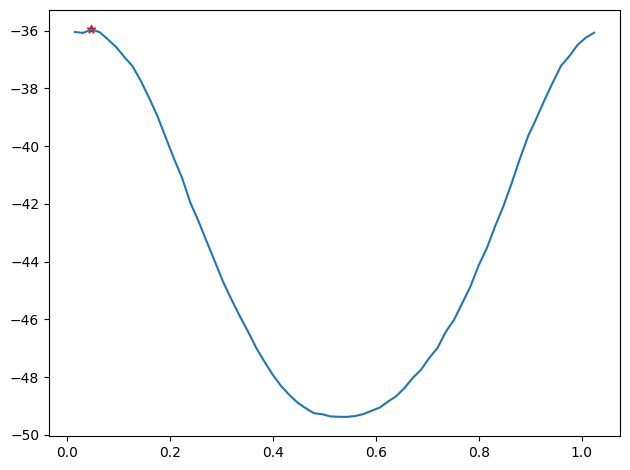

In [ ]:
### TODO:
#  1. find a way to track the maxmum value and it's location while using the integral method
#  2. Calculate the self-Diffusion Coefficient
###

In [ ]:
time = time()

In [39]:
###
#  perform 1-dim integration along channels
###

# bounds in fractional coordinates
lower_bound = 0.0
upper_bound = 1.0


(val, err) = hquadrature(xf -> integrand(xf, xtals[:nipyc], adsorbates[:Xe][:molecule], 
                                         segmented_grid, acc_grid, seg_id=1, dim=q_axis, nb_insertions=1e3),
                         lower_bound, upper_bound, reltol=1e-3, abstol=0, maxevals=0)

LoadError: InterruptException:

In [ ]:
ellapsed_time = (time() - time) / 60 # miutes